In [2]:
import matplotlib.pyplot as plt

import pyBeamSim
import numpy as np
import pandas as pd
import torch
import torch.nn as nn


In [3]:
df = pd.read_csv('data/data.csv', index_col=0)
df

,drift1_len,quad1_len,quad1_gra,drift2_len,quad2_len,quad2_gra,x_avg0,x_avg1,x_avg2,x_avg3,x_avg4
0,0.180365,0.142677,6.547704,0.225119,0.470313,-11.542837,-2.582750e-09,0.000020,-1.334003e-06,-0.000014,-0.000038
1,0.432852,0.169020,6.902478,0.289684,0.324885,-3.967744,-2.582750e-09,0.000031,-9.403697e-07,-0.000015,-0.000009
2,0.362458,0.471569,-12.758745,0.362968,0.284895,-14.773666,-2.582750e-09,0.000028,-1.458700e-06,-0.000608,-0.000334
3,0.466958,0.285071,-1.812787,0.419730,0.220902,-3.831353,-2.582750e-09,0.000029,-8.623525e-07,-0.000074,-0.000219
4,0.387841,0.265736,0.708887,0.271929,0.493496,-5.513117,-2.582750e-09,0.000041,-2.424351e-06,-0.000107,-0.000205
...,...,...,...,...,...,...,...,...,...,...,...
995,0.302903,0.244454,-12.081781,0.204627,0.396996,-13.567693,-2.582750e-09,0.000031,2.022189e-06,0.000107,-0.000076
996,0.186791,0.292417,7.818244,0.106194,0.355064,9.314740,-2.582750e-09,0.000021,-3.552524e-06,-0.000037,-0.000004
997,0.370323,0.202365,-19.998472,0.463314,0.126357,-3.632991,-2.582750e-09,0.000037,-3.015456e-06,-0.000358,-0.000127
998,0.474896,0.425611,7.057482,0.251108,0.434101,12.805979,-2.582750e-09,0.000029,7.783686e-09,-0.000100,0.000105


### data analysis

### Dataset and DataLoader

In [4]:
# hyperparams

input_size = 1
hidden_size = 30
output_size = 1
output_len = 4

num_epochs = 100
learning_rate = 0.001


In [5]:
# last 4 columns as y_true
X = df.iloc[:, :-4]
y = df.iloc[:, -4:]
# transform df into tensor
X = torch.Tensor(X.values).unsqueeze(2) # add a dim: input_size
y = torch.Tensor(y.values)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [6]:
print(f'y_train.shape: {y_train.shape}')
print(f'X_train.shape: {X_train.shape}')

y_train.shape: torch.Size([800, 4])
X_train.shape: torch.Size([800, 7, 1])


In [7]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 8

# generate dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [8]:
train_dataset[0]

(tensor([[ 1.7973e-01],
         [ 4.0641e-01],
         [-4.2190e+00],
         [ 1.7880e-01],
         [ 4.3545e-01],
         [ 1.0347e-01],
         [-2.5827e-09]]),
 tensor([ 2.0317e-05,  1.2282e-06,  4.8297e-05, -3.5154e-05]))

In [9]:
for i, (a, b) in enumerate(train_loader):
    print(a.shape)
    print(b.shape)
    if i ==0:
        break

torch.Size([8, 7, 1])
torch.Size([8, 4])


### train

In [10]:
import torch.optim as optim
from model import Model, Model2, MLP

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# test_criterion = nn.MSELoss(reduction='sum')

In [11]:
# time-series, not accuracy, but mse instead.
def val_acc(ml, val_loader, device):
    ml.eval()
    total_acc = 0
    with torch.no_grad():
        if isinstance(ml, Model):
            for X_test, y_test in val_loader:
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                y_pred = ml(X_test)
                # test_criterion = nn.MSELoss(reduction='sum')
                test_criterion = nn.L1Loss()
                acc = test_criterion(y_pred, y_test)
                total_acc += acc
        elif isinstance(ml, Model2):
             for X_test, y_test in val_loader:
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                y_pred = ml(X_test, y[:, :1])
                test_criterion = nn.L1Loss()
                acc = test_criterion(y_pred, y[:, 1:])
                total_acc += acc
        elif isinstance(ml, MLP):
            for X_test, y_test in val_loader:
                X_test = X_test.squeeze(2).to(device)
                y_test = y_test.to(device)
                y_pred = ml(X_test)
                test_criterion = nn.L1Loss()
                acc = test_criterion(y_pred, y_test)
                total_acc += acc
        else:
            for X_test, y_test in val_loader:
                X_test = X_test.squeeze(2).to(device)
                y_test = y_test.to(device)
                y_pred = ml(X_test)
                test_criterion = nn.L1Loss()
                acc = test_criterion(y_pred, y_test)
                total_acc += acc
    return total_acc

def get_mape(tensor_true, tensor_pred):
    return torch.mean(torch.abs((tensor_pred - tensor_true) / tensor_true)) * 100

In [12]:
# device = torch.device('cpu')    # cpu train succeed
# Model
model = Model(input_size, hidden_size, output_size, output_len, device)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# now cpu
losses = []
test_accuracies = []

# add model before training
test_acc = val_acc(model, val_loader=test_loader, device=device)
test_accuracies.append(test_acc.cpu().numpy())

for epoch in range(num_epochs):
    if epoch == 0:
        print(f'the training is using {device}')
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        total_loss += loss
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    test_acc = val_acc(model, val_loader=test_loader, device=device)
    test_accuracies.append(test_acc.cpu().numpy())
    losses.append(total_loss.cpu().detach().numpy())
    print(f'epoch{epoch+1}: loss: {total_loss:8f}')

the training is using cuda
epoch1: loss: 0.659498
epoch2: loss: 0.078014
epoch3: loss: 0.064881
epoch4: loss: 0.064559
epoch5: loss: 0.042303
epoch6: loss: 0.068283
epoch7: loss: 0.055768
epoch8: loss: 0.055927
epoch9: loss: 0.049856
epoch10: loss: 0.043746
epoch11: loss: 0.045946
epoch12: loss: 0.032973
epoch13: loss: 0.034901
epoch14: loss: 0.031623
epoch15: loss: 0.039698
epoch16: loss: 0.032471
epoch17: loss: 0.033845
epoch18: loss: 0.051535
epoch19: loss: 0.033286
epoch20: loss: 0.027669
epoch21: loss: 0.037588
epoch22: loss: 0.031303
epoch23: loss: 0.036431
epoch24: loss: 0.036293
epoch25: loss: 0.029444
epoch26: loss: 0.029561
epoch27: loss: 0.024341
epoch28: loss: 0.048211
epoch29: loss: 0.034623
epoch30: loss: 0.036399
epoch31: loss: 0.025907
epoch32: loss: 0.032927
epoch33: loss: 0.032352
epoch34: loss: 0.021087
epoch35: loss: 0.028468
epoch36: loss: 0.027587
epoch37: loss: 0.025915
epoch38: loss: 0.023477
epoch39: loss: 0.028274
epoch40: loss: 0.023235
epoch41: loss: 0.01962

In [13]:
# Model2
model2 = Model2(input_size, hidden_size, output_size, output_len)
model2.to(device)

optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

# now cpu
losses2 = []
test_accuracies2 = []
test_acc = val_acc(model2, val_loader=test_loader, device=device)
test_accuracies2.append(test_acc.cpu().numpy())

for epoch in range(num_epochs):
    if epoch == 0:
        print(f'the training is using {device}')
    model2.train()
    total_loss = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device) # two-dim tensor
        y_pred = model2(X, y[:, :1])
        loss = criterion(y_pred, y[:, 1:])
        total_loss += loss
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    test_acc = val_acc(model2, val_loader=test_loader, device=device)
    test_accuracies2.append(test_acc.cpu().numpy())
    losses2.append(total_loss.cpu().detach().numpy()) # to cpu to plot
    print(f'epoch{epoch+1}: loss: {total_loss:.8f}')

the training is using cuda
epoch1: loss: 1.397376
epoch2: loss: 0.093132
epoch3: loss: 0.072523
epoch4: loss: 0.063752
epoch5: loss: 0.091133
epoch6: loss: 0.075553
epoch7: loss: 0.078226
epoch8: loss: 0.053052
epoch9: loss: 0.052530
epoch10: loss: 0.092543
epoch11: loss: 0.058331
epoch12: loss: 0.061346
epoch13: loss: 0.053452
epoch14: loss: 0.063914
epoch15: loss: 0.104482
epoch16: loss: 0.050067
epoch17: loss: 0.041852
epoch18: loss: 0.057323
epoch19: loss: 0.046425
epoch20: loss: 0.061201
epoch21: loss: 0.054621
epoch22: loss: 0.062408
epoch23: loss: 0.048675
epoch24: loss: 0.051405
epoch25: loss: 0.047862
epoch26: loss: 0.047203
epoch27: loss: 0.046961
epoch28: loss: 0.045262
epoch29: loss: 0.040719
epoch30: loss: 0.040185
epoch31: loss: 0.044334
epoch32: loss: 0.040629
epoch33: loss: 0.040681
epoch34: loss: 0.047959
epoch35: loss: 0.052981
epoch36: loss: 0.043693
epoch37: loss: 0.036004
epoch38: loss: 0.028866
epoch39: loss: 0.034889
epoch40: loss: 0.037768
epoch41: loss: 0.03053

In [14]:
# MLP
#mlp = MLP(input_size=6)
mlp = nn.Sequential(nn.Linear(7, 32),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(32, 64),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(32, 16),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(16, 4),
                    )
mlp.to(device)

optimizer = optim.Adam(mlp.parameters(), lr=0.1)

losses3 = []
test_accuracies3 = []
test_acc = val_acc(mlp, val_loader=test_loader, device=device)
test_accuracies3.append(test_acc.cpu().numpy())

for epoch in range(num_epochs):
    if epoch == 0:
        print(f'the training is using {device}')
    mlp.train()
    total_loss = 0
    for X, y in train_loader:
        X = X.squeeze(2).to(device)
        y = y.to(device) # two-dim tensor
        y_pred = mlp(X)
        loss = criterion(y_pred, y)
        total_loss += loss
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    test_acc = val_acc(mlp, val_loader=test_loader, device=device)
    test_accuracies3.append(test_acc.cpu().numpy())
    losses3.append(total_loss.cpu().detach().numpy()) # to cpu to plot
    print(f'epoch{epoch+1}: loss: {total_loss:.8f}')


the training is using cuda
epoch1: loss: 14.554315
epoch2: loss: 1.513187
epoch3: loss: 1.496991
epoch4: loss: 1.530676
epoch5: loss: 1.524736
epoch6: loss: 1.523342
epoch7: loss: 1.515207
epoch8: loss: 1.505435
epoch9: loss: 1.492980
epoch10: loss: 1.527834
epoch11: loss: 1.523467
epoch12: loss: 1.522135
epoch13: loss: 1.514188
epoch14: loss: 1.504977
epoch15: loss: 1.492699
epoch16: loss: 1.527471
epoch17: loss: 1.522907
epoch18: loss: 1.521888
epoch19: loss: 1.514061
epoch20: loss: 1.504707
epoch21: loss: 1.492366
epoch22: loss: 1.526745
epoch23: loss: 1.522592
epoch24: loss: 1.521875
epoch25: loss: 1.513100
epoch26: loss: 1.504349
epoch27: loss: 1.492073
epoch28: loss: 1.527184
epoch29: loss: 1.522942
epoch30: loss: 1.521660
epoch31: loss: 1.513329
epoch32: loss: 1.504685
epoch33: loss: 1.492010
epoch34: loss: 1.526895
epoch35: loss: 1.522949
epoch36: loss: 1.521818
epoch37: loss: 1.513214
epoch38: loss: 1.504266
epoch39: loss: 1.491859
epoch40: loss: 1.527050
epoch41: loss: 1.5226

In [15]:
from torchsummary import summary
# summary(model, (1, 2), batch_size)
torch.save(model2.state_dict(), 'model_save/LSTM2.pth')

### loss and acc(sum mse here) curve
MSEloss~acc 

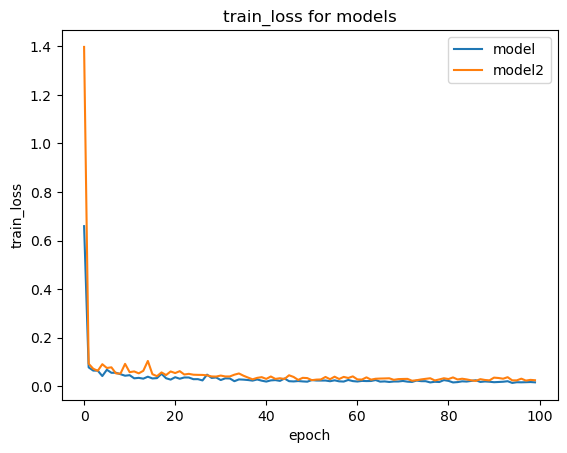

In [16]:
# Use tensor.detach().numpy()
plt.title("train_loss for models")
plt.plot(losses, label="model")
plt.plot(losses2, label="model2")
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.legend()

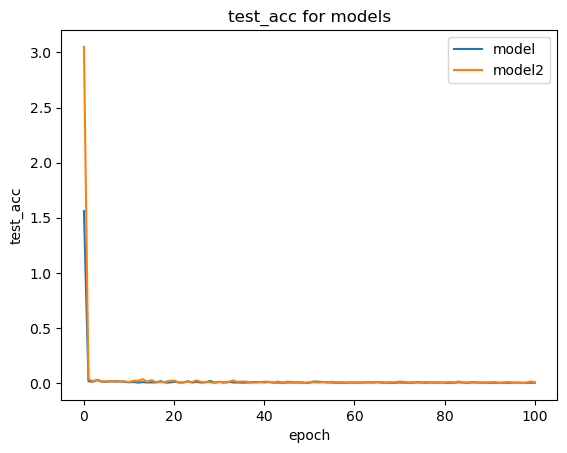

In [17]:
plt.title("test_acc for models")
plt.xlabel("epoch")
plt.ylabel("test_acc")
plt.plot(test_accuracies, label="model")
plt.plot(test_accuracies2, label="model2")
plt.legend()

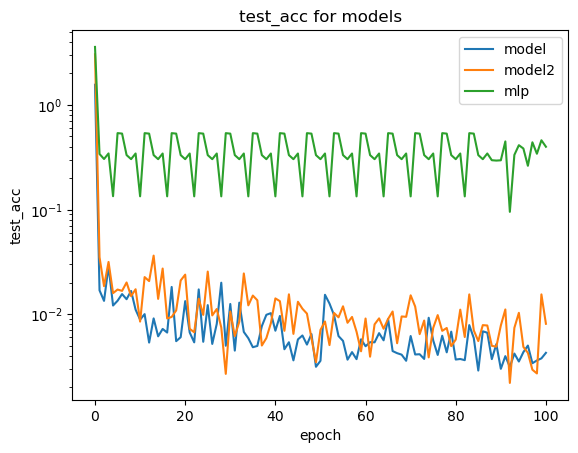

In [18]:
plt.title("test_acc for models")
plt.xlabel("epoch")
plt.ylabel("test_acc")
plt.plot(test_accuracies, label="model")
plt.plot(test_accuracies2, label="model2")
plt.plot(test_accuracies3, label="mlp")
plt.legend()

plt.yscale('log')

In [19]:
print(f'for each batch, X.shape:  {X.shape}')
total_loss

for each batch, X.shape:  torch.Size([8, 7])


tensor(1.3045, device='cuda:0', grad_fn=<AddBackward0>)

In [20]:
for X, y in test_loader:
    print(X.unsqueeze(1).shape)
    break

torch.Size([8, 1, 7, 1])


test

In [21]:
device = next(model.parameters()).device
print(f"Model is on device: {device}")


Model is on device: cuda:0


In [22]:
y_pred.shape

torch.Size([8, 4])

In [23]:
y_pred[:1, :]

tensor([[ 0.0254, -0.0108, -0.0182,  0.0041]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [24]:
y[:1, 1:]

tensor([[-2.0701e-06, -2.1330e-04,  4.0888e-05]])

In [25]:
X_test = X_test.to(device)
y_test = y_test.to(device)
model2(X_test, y_test[:, :1]).shape

torch.Size([200, 3])

### evaluate 

In [26]:
model.eval()
X_test = X_test.to(device)
y_test = y_test.to(device)
model2(X, y[:, :1])

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

In [ ]:
y[:, :]

In [ ]:
X.device

In [ ]:
len(test_accuracies)